$\textbf{PROGRAMMING ASSIGNMENT - LECTURE 6}$
---

Data: https://archive.ics.uci.edu.

Instructions:
1. Choose a unique dataset from: https://archive.ics.uci.edu
2. Your dataset should be unique from your classmates otherwise no points will be given for this exercise.

---
## Dataset: Facebook Live Sellers in Thailand

In [97]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


Access Dataset

In [98]:
df = pd.DataFrame(pd.read_csv('Datasets/Live_20210128.csv'))
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


---
## $\textbf{Data Exploration}$
### $\textbf{Create a Correlation Heatmap}$

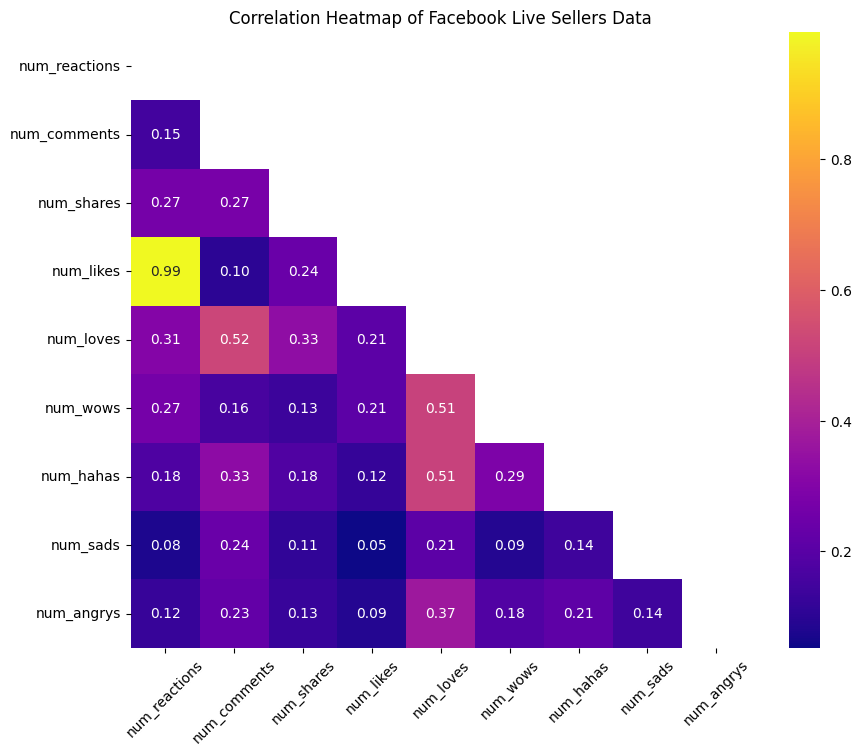

In [99]:
df.columns = ['status_id', 'status_type', 'status_published', 'num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys', 'Column1', 'Column2', 'Column3', 'Column4']
df['num_shares'] = df['num_shares'].apply(lambda x: 0 if x == 0 else 1)
columns = ['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
df_corr = df[columns]
corr_matrix = df_corr.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', fmt='.2f', mask=mask)
plt.title('Correlation Heatmap of Facebook Live Sellers Data')
plt.xticks(rotation=45)
plt.show()

### $\textbf{Determine the Top 5 Correlated Frequences with the target/label}$

In [100]:
corr_series = corr_matrix.unstack()
corr_series = corr_series.abs().sort_values(ascending=False)
corr_series = corr_series[corr_series.index.get_level_values(0) != corr_series.index.get_level_values(1)]

top_5_correlations = corr_series.head(10)
top_5_unique = top_5_correlations[::2]

print("Top 5 unique absolute correlations:\n")
print(top_5_unique)

Top 5 unique absolute correlations:

num_likes     num_reactions    0.994923
num_comments  num_loves        0.521223
num_wows      num_loves        0.508798
num_hahas     num_loves        0.507830
num_angrys    num_loves        0.371001
dtype: float64


---
## $\textbf{Train | Test Split}$
### $\textbf{Split the data into features and labels}$

In [101]:
df.drop(columns=['Column1', 'Column2', 'Column3', 'Column4'], inplace=True)

# Define features and labels
X = df.drop('num_reactions', axis=1)
y = df['num_reactions']

X['status_published'] = pd.to_datetime(X['status_published'])
X['year'] = X['status_published'].dt.year
X['month'] = X['status_published'].dt.month
X['day'] = X['status_published'].dt.day
X['hour'] = X['status_published'].dt.hour

X.drop(columns=['status_published'], inplace=True)

categorical_features = ['status_type']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

X_transformed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(scaled_X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

### $\textbf{Create a PipeLine that contains both a StandardScaler and a KNN model}$

In [102]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=1))
])

pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)
print(f'Model accuracy: {score:.2f}')

Model accuracy: 0.04


### $\textbf{Perform a grid-search with the pipeline to test various values of k and report back the best performing parameters.}$

In [106]:
import warnings
warnings.filterwarnings('ignore')

param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_:.2f}')

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f'Test set accuracy: {test_accuracy:.2f}')

Best parameters: {'knn__n_neighbors': 1}
Best cross-validation accuracy: 0.05
Test set accuracy: 0.04


### $\textbf{Create a plot of the mean test score per K value}$

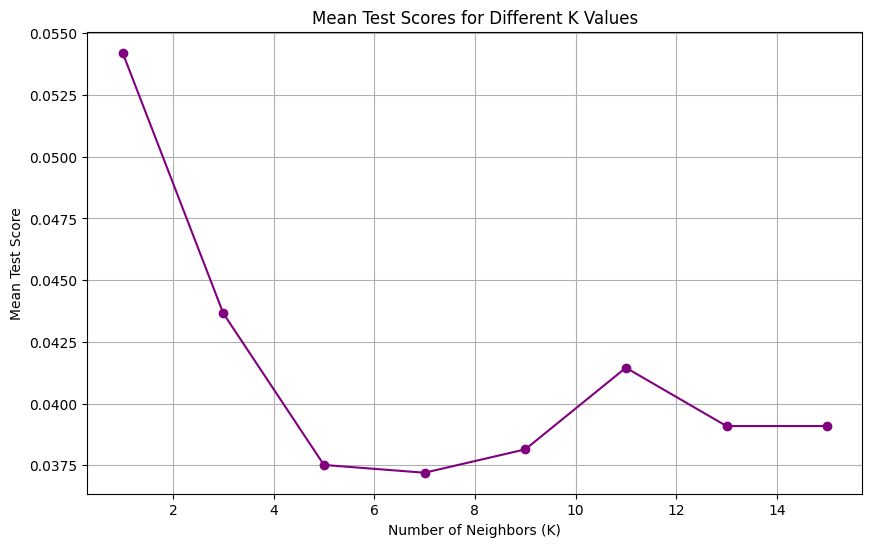

In [110]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
param_k_values = grid_search.cv_results_['param_knn__n_neighbors']

plt.figure(figsize=(10, 6))
plt.plot(param_k_values, mean_test_scores, marker='o', color='purple')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Scores for Different K Values')
plt.grid(True)
plt.show()

---
## $\textbf{Final Model Evaluation}$
### $\textbf{Final performance classification report and confusion matrix.}$

In [111]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming grid_search is the fitted GridSearchCV object
# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.40      0.32        10
           1       0.27      0.21      0.24        14
           2       0.20      0.19      0.19        16
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         4
           6       0.12      0.20      0.15         5
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         7
          10       0.14      0.10      0.12        10
          11       0.08      0.12      0.10         8
          12       0.00      0.00      0.00        10
          13       0.07      0.14      0.09         7
          14       0.07      0.06      0.06        17
          15       0.07      0.09      0.08        11
          16       0.00      0.00      0.00        10
    